<a href="https://colab.research.google.com/github/VMBoehm/UndergradStudentProjects/blob/master/Jamie_and_Lister/VanessasNotebooks/PeakCounts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# applying our methods to lensing convergence peak counts

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:

datapath='../data/'


### the paper: https://arxiv.org/pdf/1810.01781.pdf

### load the data

In [4]:
# these are the peaks counts
data_scaled = np.load(datapath+'peakcnts_lhc.scaled.npy',allow_pickle=True)
# these are the cosmo params
cosmo_params = np.load(datapath+'params.npy')
# this is the covariance for the likleihood
covariance = np.load(datapath+'covariance.npy',allow_pickle=True)

In [5]:
# 101 cosmologies, 10000 simulations per cosmology, 50 density bins (levels of 'flooding')
data_scaled.shape

(101, 9999, 50)

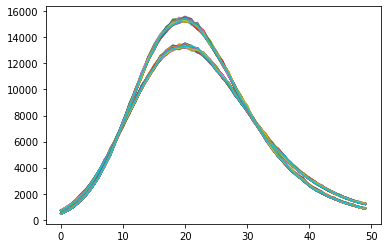

In [149]:
# this is what the data looks like for 2 different cosmologies
plt.plot(data_scaled[40,0:100,:].T)
plt.plot(data_scaled[44,0:100,:].T)
plt.show()

### The data

In [173]:
# We pick a realization at a specific cosmology to be our data (you can change this!)
# right now we choose a cosmology which is fairly close to the fiducial one (see below)
index = 54
data  = data_scaled[index][0]
true_params = cosmo_params[index]
print(true_params)

[0.124  0.3028 2.3174]


### Covariance Matrix

In [171]:
# compute covariance from covariance sims
Cinv = np.linalg.inv(covariance)

In [172]:
# these are the fiducial parameter, i.e. the parameters the covariance was measured at 
fid_params = np.load(datapath+'theta.fid.npy',allow_pickle=True)
print(fid_params)

[0.1 0.3 2.1]


### Constructing the data likelihood

In [153]:
# average over all simulations for each cosmology
means      = np.mean(data_scaled, axis=1)

#### Forward Model: Gaussian process interpolation of  means

In [154]:
# A Gaussian process is a regression model, it learns to map x-> f(x) from some training data. 
# In our case x are the cosmological parameters and f(x) are the peak counts

import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on means and parameters
gp.fit(cosmo_params,means)

#use the GP prediction to build the model
def fwdmodel(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return np.squeeze(pred.T)




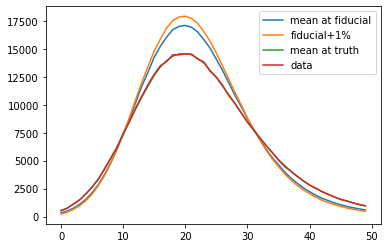

In [155]:
# Check how well the Gaussian process is doing

plt.plot(fwdmodel(fid_params), label='mean at fiducial')
plt.plot(fwdmodel(fid_params*1.01), label= 'fiducial+1%')
plt.plot(fwdmodel(true_params), label='mean at truth')
plt.plot(data, label='data')
plt.legend()
plt.show()

In [156]:
# likelihood
# We assume a Gaussian likelihood for the peak counts. 
# Can you think of reasons why this is a reasonable assumption?
# Hint: Peak counts are a binned statistic (a sum of a random number)

def likelihood(data, params):
    mu  = fwdmodel(params)
    x   = data - mu
    # linalg.slogdet is numerically more stable than np.log(linalg.det())
    _, logdet = np.linalg.slogdet(Cinv)
    x   = np.squeeze(x)
    logp= -0.5*np.dot(np.dot(x, Cinv),x)+0.5*logdet-0.5*len(x)*np.log(2*np.pi)
    return np.squeeze(logp)

In [157]:
# check if output makes sense
-likelihood(data,true_params)

426.4627767277797

### posterior

In [158]:
# posterior    = prior*likelihood
# logposterior = loglikelihood+logprior
# task: add a Gaussian prior on the parameters. This prior shouls be centered around the fiducial parameter values,
# for now let's assume the parameters are uncorrelated, and the sigma is 10% of the parameter value
# construct the posterior



In [159]:
# replace likelihood by posterior
neglogpost = lambda x: -likelihood(data, x)

### derivatives

In [160]:
import numdifftools as nd

In [161]:
# gradient
grad = nd.Gradient(neglogpost)

In [162]:
# hessian
hess = nd.Hessian(neglogpost)

In [163]:
# derivative by hand
def derivative(params):
    # have to choose delta really small here
    delta_params=1e-5*fid_params
    deriv = np.zeros(len(params))
    for ii in range(len(params)):
        deltas = np.zeros(len(params))
        deltas[ii]+=delta_params[ii]
        deriv[ii] = (neglogpost(params+deltas)-neglogpost(params-deltas))/(2*delta_params[ii])
    return deriv

In [164]:
## numerical differences! (points towards nasty likleihood surface)
grad(true_params), derivative(true_params)

(array([ 2.59371136,  0.98967232, -2.43481201]),
 array([ 2.59371132,  0.98967206, -2.43481161]))

### find minima

In [178]:
## you can try different minimizers here. Do they all find the same minima? Which ones work and which ones fail?
## what happens is the fiducial parameters are far from the truth?

import warnings
from scipy.optimize import minimize

log_posts = [] 
param_ests= []
with warnings.catch_warnings(record=True):
    for theta_ini in 0.15*np.sqrt(fid_params)*np.random.randn(10,3)+fid_params:
        for method in ['CG']:#,'Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']:
            res = minimize(neglogpost,theta_ini,jac=grad,hess=hess,method=method)
            if res['success']:
                log_posts.append(neglogpost(res['x']))
                param_ests.append(res['x'])
param_ests= np.asarray(param_ests)

[0.0862971  0.31140915 2.28362292]
[0.06745684 0.30287448 1.97523773]
[0.08271176 0.34952296 2.01380068]
[0.0689691  0.22060138 2.0966175 ]
[0.09127015 0.3394548  2.01353999]
[0.10669133 0.21253595 2.48224656]
[0.111456   0.27534288 1.84426215]
[0.1039816  0.29013474 1.94422725]
[0.08842917 0.25540761 2.00608995]
[0.12160869 0.32801672 2.11355238]


[426.51497879413256, 426.46634644263344, 426.46379098286496, 426.4664166120845, 426.4649013800206, 426.48679474119814, 426.4663464426335, 426.46767844950864]


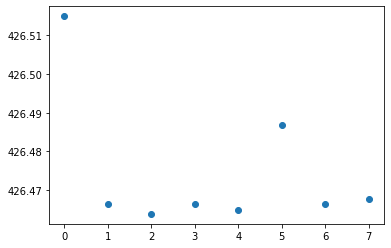

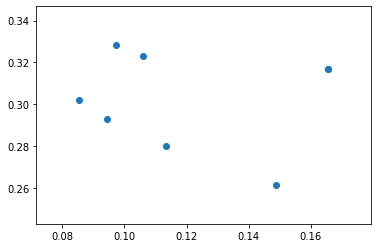

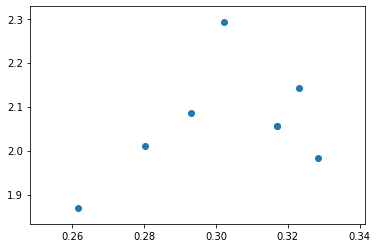

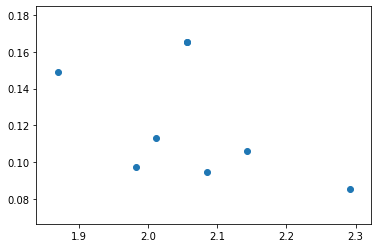

In [182]:
# did they all land in the same minimum?
print(log_posts)
plt.plot(log_posts,ls='', marker='o')
plt.show()

for ii in range(param_ests.shape[-1]):
    if ii==2:
        plt.scatter(param_ests[:,ii],param_ests[:,0])
    else:
        plt.scatter(param_ests[:,ii],param_ests[:,ii+1])
    plt.show()
# parameters are pretty much all over the place

In [183]:
### let's look at the lowest minimum
index       = np.argsort((log_posts))
print(log_posts[index[0]])
best_params = param_ests[index[0]]
print(best_params, true_params, fid_params)

426.46379098286496
[0.09432592 0.29296634 2.08533811] [0.124  0.3028 2.3174] [0.1 0.3 2.1]


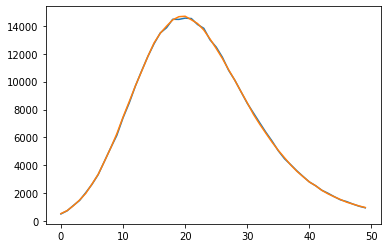

In [168]:
plt.plot(data)
plt.plot(fwdmodel(best_params))

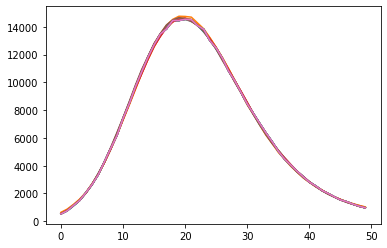

In [186]:
# let's look at all minima:
plt.plot(data)
for ii in range(len(param_ests)):
    plt.plot(fwdmodel(param_ests[ii]))
    plt.plot(data)
## all of them seem to be consistent with the data!

In [187]:
# what do we learn from this about the psoterior?